# Finetune a stable diffusion model for text to image generation

***
Welcome to Amazon [SageMaker JumpStart](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)! You can use JumpStart to solve many Machine Learning tasks through one-click in SageMaker Studio, or through [SageMaker JumpStart API](https://sagemaker.readthedocs.io/en/stable/overview.html#use-prebuilt-models-with-sagemaker-jumpstart).  In this demo notebook, we demonstrate how to use the JumpStart API to generate images from text using state-of-the-art Stable Diffusion models. Furthermore, we show how to fine-tune the model to your dataset.

Stable Diffusion is a text-to-image model that enables you to create photorealistic images from just a text prompt. A diffusion model trains by learning to remove noise that was added to a real image. This de-noising process generates a realistic image. These models can also generate images from text alone by conditioning the generation process on the text. For instance, Stable Diffusion is a latent diffusion where the model learns to recognize shapes in a pure noise image and gradually brings these shapes into focus if the shapes match the words in the input text.

Training and deploying large models and running inference on models such as Stable Diffusion is often challenging and include issues such as cuda out of memory, payload size limit exceeded and so on.  JumpStart simplifies this process by providing ready-to-use scripts that have been robustly tested. Furthermore, it provides guidance on each step of the process including the recommended instance types, how to select parameters to guide image generation process, prompt engineering etc. Moreover, you can deploy and run inference on any of the 80+ Diffusion models from JumpStart without having to write any piece of your own code.


In his notebook, you will learn how to use JumpStart to fine-tune the Stable Diffusion model to your dataset. This can be useful when creating art, logos, custom designs, NFTs, and so on, or fun stuff such as generating custom AI images of your pets or avatars of yourself.


Model lincese: By using this model, you agree to the [CreativeML Open RAIL-M++ license](https://huggingface.co/stabilityai/stable-diffusion-2/blob/main/LICENSE-MODEL).

***

1. [Set Up](#1.-Set-Up)
2. [Fine-tune the pre-trained model on a custom dataset](#2.-Fine-tune-the-pre-trained-model-on-a-custom-dataset)
    * [Retrieve Training Artifacts](#2.1.-Retrieve-Training-Artifacts)
    * [Set Training parameters](#2.2.-Set-Training-parameters)
    * [Start Training](#2.3.-Start-Training)
    * [Deploy and run inference on the fine-tuned model](#3.2.-Deploy-and-run-inference-on-the-fine-tuned-model)
3. [Conclusion](#3.-Conclusion)


Note: This notebook was tested on ml.t3.medium instance in Amazon SageMaker Studio with Python 3 (Data Science) kernel and in Amazon SageMaker Notebook instance with conda_python3 kernel.

Note: For fine-tuning the model on your dataset, you need `ml.g4dn.2xlarge` instance type available in your account. To deploy the fine-trained model, you can use `ml.p3.2xlarge` or `ml.g4dn.2xlarge` instance types. If `ml.g5.2xlarge` is available in your region, we recommend using that instance type for deployment. 

## 1. Set Up

***
Before executing the notebook, there are some initial steps required for set up. This notebook requires latest version of sagemaker.

***

#### Permissions and environment variables

***
To host on Amazon SageMaker, we need to set up and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook as the AWS account role with SageMaker access.

***

In [2]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2. Fine-tune the pre-trained model on a custom dataset

---
Previously, we saw how to run inference on a pre-trained model. Next, we discuss how a model can be finetuned to a custom dataset with any number of classes.

The model can be fine-tuned to any dataset of images. It works very well even with as little as five training images.

The fine-tuning script is built on the script from [dreambooth](https://dreambooth.github.io/). The model returned by fine-tuning can be further deployed for inference. Below are the instructions for how the training data should be formatted.

- **Input:** A directory containing the instance images, `dataset_info.json` and (optional) directory `class_data_dir`.
  - Images may be of `.png` or `.jpg` or `.jpeg` format.
  - `dataset_info.json` file must be of the format {'instance_prompt':<<instance_prompt>>,'class_prompt':<<class_prompt>>}.
  - If with_prior_preservation = False, you may choose to ignore 'class_prompt'.
  - `class_data_dir` directory must have class images. If with_prior_preservation = True and class_data_dir is not present or there are not enough images already present in class_data_dir, additional images will be sampled with class_prompt.
- **Output:** A trained model that can be deployed for inference.

The s3 path should look like `s3://bucket_name/input_directory/`. Note the trailing `/` is required.

Here is an example format of the training data.

    input_directory
        |---instance_image_1.png
        |---instance_image_2.png
        |---instance_image_3.png
        |---instance_image_4.png
        |---instance_image_5.png
        |---dataset_info.json
        |---class_data_dir
            |---class_image_1.png
            |---class_image_2.png
            |---class_image_3.png
            |---class_image_4.png

**Prior preservation, instance prompt and class prompt:** Prior preservation is a technique that uses additional images of the same class that we are trying to train on.  For instance, if the training data consists of images of a particular dog, with prior preservation, we incorporate class images of generic dogs. It tries to avoid overfitting by showing images of different dogs while training for a particular dog. Tag indicating the specific dog present in instance prompt is missing in the class prompt. For instance, instance prompt may be "a photo of a Doppler dog" and class prompt may be "a photo of a dog". You can enable prior preservation by setting the hyper-parameter with_prior_preservation = True.



We provide a default dataset of dog images. It consists of images (instance images corresponding to instance prompt) of a single dog with no class images. If using the default dataset, try the prompt "a photo of a Doppler dog" while doing inference in the demo notebook.


License: [MIT](https://github.com/marshmellow77/dreambooth-sm/blob/main/LICENSE).

### 2.1. Retrieve Training Artifacts

---
Here, we retrieve the training docker container, the training algorithm source, and the pre-trained base model. Note that model_version="*" fetches the latest model.

---

In [167]:
from sagemaker import image_uris, model_uris, script_uris

# Currently, not all the stable diffusion models in jumpstart support finetuning. Thus, we manually select a model
# which supports finetuning.
train_model_id, train_model_version, train_scope = (
    "model-txt2img-stabilityai-stable-diffusion-v2-1-base",
    "*",
    "training",
)

# Tested with ml.g4dn.2xlarge (16GB GPU memory) and ml.g5.2xlarge (24GB GPU memory) instances. Other instances may work as well.
# If ml.g5.2xlarge instance type is available, please change the following instance type to speed up training.
training_instance_type = "ml.g4dn.2xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)

# Retrieve the training script. This contains all the necessary files including data processing, model training etc.
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


### 2.2. Set Training parameters

---
Now that we are done with all the set up that is needed, we are ready to train our stable diffusion model. To begin, let us create a [``sageMaker.estimator.Estimator``](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object. This estimator will launch the training job.

There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include: (i) Training data path. This is S3 folder in which the input data is stored, (ii) Output path: This the s3 folder in which the training output is stored. (iii) Training instance type: This indicates the type of machine on which to run the training. We defined the training instance type above to fetch the correct train_image_uri.

The second set of parameters are algorithm specific training hyper-parameters.

---

In [168]:
# Sample training data is available in this bucket
training_data_bucket = f"jumpstart-cache-prod-{aws_region}"
training_data_prefix = "training-datasets/dogs_sd_finetuning/"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"

output_bucket = sess.default_bucket()
output_prefix = "jumpstart-example-sd-training"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

---
For algorithm specific hyper-parameters, we start by fetching python dictionary of the training hyper-parameters that the algorithm accepts with their default values. This can then be overridden to custom values.

---

In [169]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters["max_steps"] = "400"
print(hyperparameters)

{'epochs': '20', 'max_steps': '400', 'batch_size': '1', 'with_prior_preservation': 'False', 'num_class_images': '100', 'learning_rate': '2e-06', 'prior_loss_weight': '1.0', 'center_crop': 'False', 'lr_scheduler': 'constant', 'adam_weight_decay': '0.01', 'adam_beta1': '0.9', 'adam_beta2': '0.999', 'adam_epsilon': '1e-08', 'gradient_accumulation_steps': '1', 'max_grad_norm': '1.0', 'compute_fid': 'False', 'seed': '0'}


---
If setting `with_prior_preservation=True`, please use ml.g5.2xlarge instance type as more memory is required to generate class images. Currently, training on ml.g4dn.2xlarge instance type run into CUDA out of memory issue when setting `with_prior_preservation=True`.

---

### 2.3. Start Training
---
We start by creating the estimator object with all the required assets and then launch the training job.  It takes less than 10 mins on the default dataset.

---

- angry : model-txt2img-stabilityai-stable-diffus-2023-04-19-21-40-15-172
- calm : model-txt2img-stabilityai-stable-diffus-2023-04-19-21-50-11-408
- confused : model-txt2img-stabilityai-stable-diffus-2023-04-19-22-05-13-449

In [309]:
feeling='disgusted'

In [310]:
# training_instance_type='ml.g4dn.2xlarge'
training_instance_type='ml.g5.2xlarge'
# training_instance_type='ml.g4dn.4xlarge'

In [311]:
training_egarden_s3_path = f's3://dataset-us-west-2-cyj/stable-diffusion-finetune/data_crawling/{feeling}-nature/'
# training_egarden_s3_path = f's3://dataset-us-west-2-cyj/stable-diffusion-finetune/face-image/'

In [312]:
name_from_base(f"jumpstart-example-{train_model_id}-transfer-learning")[23:]

'-txt2img-stabili-2023-04-21-07-27-11-271'

In [313]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base
from sagemaker.tuner import HyperparameterTuner

training_job_name = feeling + name_from_base(f"jumpstart-example-{train_model_id}-transfer-learning")[23:]

# Create SageMaker Estimator instance
sd_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir="train_code",
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",  # Entry-point file in source_dir and present in train_source_uri.
    instance_count=1,
    instance_type=training_instance_type,
    # max_run=360000,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
    # base_job_name=training_job_name,
)


In [314]:
# Launch a SageMaker Training job by passing s3 path of the training data
sd_estimator.fit(
    job_name=training_job_name,
    inputs={"training": training_egarden_s3_path}, 
    logs=True,
    wait=False
)

INFO:sagemaker:Creating training-job with name: disgusted-txt2img-stabili-2023-04-21-07-27-11-496


In [315]:
sd_estimator.logs()

2023-04-21 07:27:21 Starting - Starting the training job...
2023-04-21 07:27:36 Starting - Preparing the instances for training...
2023-04-21 07:28:22 Downloading - Downloading input data...............
2023-04-21 07:30:58 Training - Training image download completed. Training in progress.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-21 07:31:24,885 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-21 07:31:24,906 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-21 07:31:24,908 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-21 07:31:26,522 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -r requirements.txt
Processing ./lib/accelerate/accelerate-0.15.0-py3-none-any.whl
Processing ./lib/bitsandbytes/bitsa

### 2.4. Deploy and run inference on the fine-tuned model

---

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the bounding boxes of an image. We follow the same steps as in [2. Run inference on the pre-trained model](#2.-Run-inference-on-the-pre-trained-model). We start by retrieving the jumpstart artifacts for deploying an endpoint. However, instead of base_predictor, we  deploy the `od_estimator` that we fine-tuned.

---

In [440]:
inference_instance_type = "ml.p4d.24xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri. This includes scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

In [441]:
endpoint_name = name_from_base(f"jumpstart-example-FT-{train_model_id}-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
finetuned_predictor = sd_estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    image_uri=deploy_image_uri,
    source_dir="src",
    endpoint_name=endpoint_name,
)

INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2023-04-21-14-28-39-496
INFO:sagemaker:Creating endpoint-config with name jumpstart-example-FT-model-txt2img-stab-2023-04-21-14-28-39-496
INFO:sagemaker:Creating endpoint with name jumpstart-example-FT-model-txt2img-stab-2023-04-21-14-28-39-496


------------!

Next, we query the finetuned model, parse the response and display the generated image. Functions for these are implemented below. Input to the endpoint is any string of text dumped in json and encoded in `utf-8` format. Output of the endpoint is a json with generated text.

In [286]:
# finetuned_predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_name)

In [319]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = text.encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response

def query_prompt(model_predictor, payload):
    """Query the model predictor."""

    encoded_payload = json.dumps(payload).encode("utf-8")

    query_response = model_predictor.predict(
        encoded_payload,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response

def parse_response(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_image"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display hallucinated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

In [322]:
# text = 'botanic garden with (dog: 2.0) and (bugs), very extremely (disgusted: 3.5) nature, (((dizziness and discomfort))), psychedelic, best quality, (sunny: 3.0), (spring: 2.5), surrealist, hyperrealistic, cinematic lighting, dramatic angle, wide angle view, yellow and ((green)), by Ernst Ludwig Kirchner and Wassily Kandinsky, [real artisation: illustration: 0.4], (day: 2.0)'
text = 'botanic garden with (dog: 2.0) and (bugs), very extremely (confused: 3.5) nature, (((dizziness and discomfort))), psychedelic, best quality, (sunny: 3.0), (spring: 2.5), surrealist, hyperrealistic, cinematic lighting, dramatic angle, wide angle view, yellow and ((green)), by Ernst Ludwig Kirchner, Wassily Kandinsky and Edvard Munch, [real artisation: illustration: 0.4], (day: 2.0)'
# text = 'botanic garden with (dog: 2.0) and (bugs), very extremely (disgusted: 3.5) nature, (((dizziness and discomfort))), psychedelic, best quality, (sunny: 3.0), (spring: 2.5), surrealist, hyperrealistic, cinematic lighting, dramatic angle, low angle shot, yellow and ((green)), by Ernst Ludwig Kirchner and Wassily Kandinsky, [real artisation: illustration: 0.4], (day: 2.0)'


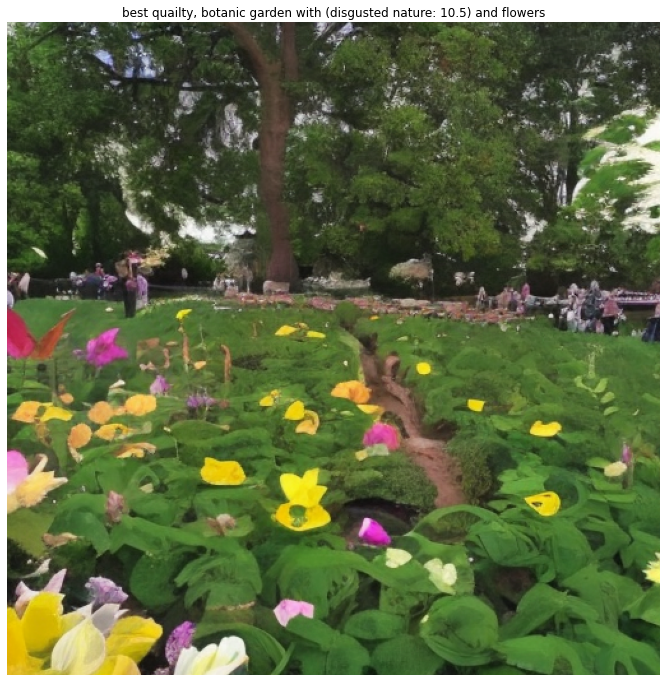

In [324]:
# text = "a photo of a dog with a hat"
# text = 'botanic garden with flowers and (no animal: 2.0), very strong (surprised: 10.5) nature, best quality, (sunny: 3.0), (spring: 2.5), surrealist, hyperrealistic, fantasy, cinematic lighting, dramatic angle, expansive view, real artisation, (day: 2.0)'
# text = 'best quality, dreamlikeart, disgusted nature, rainy, winter, real Artstation, botanical garden, flowers, cinematic lighting, dramatic angle, ((back to the viewer)), (an extremely delicate and beautiful), day'

# text = 'best quailty, botanic garden with (disgusted nature: 10.5) and flowers'

query_response = query(finetuned_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

In [331]:
payload = {
    "prompt": text,
    "width": 512,
    "height": 512,
    "num_images_per_prompt": 2,
    "num_inference_steps": 150,
    "guidance_scale": 7.5,
}

In [332]:
# query_response = query_prompt(finetuned_predictor, payload)
# img, prmpt = parse_response(query_response)
# display_img_and_prompt(img, prmpt)

In [333]:
# text = "best quality,kyoungsu as handsome guy, digital painting, hyperrealistic, highly detailed, animation ,extremely detailed by Hayao Miyazaki by Hayao Miyazaki and Alphonse Mucha"

In [334]:
import json

# Training data for different models had different image sizes and it is often observed that the model performs best when the generated image
# has dimensions same as the training data dimension. For dimensions not matching the default dimensions, it may result in a black image.
# Stable Diffusion v1-4 was trained on 512x512 images and Stable Diffusion v2 was trained on 768x768 images.
def query_endpoint_with_json_payload(model_predictor, payload, content_type, accept):
    """Query the model predictor with json payload."""

    encoded_payload = json.dumps(payload).encode("utf-8")

    query_response = model_predictor.predict(
        encoded_payload,
        {
            "ContentType": content_type,
            "Accept": accept,
        },
    )
    return query_response


def parse_response_multiple_images(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_images"], response_dict["prompt"]


In [335]:
# text = 'best quality, botanic garden with (cat: 2.0) and (bugs), very extremely (disgusted: 3.5) nature, \
#         (((dizziness and discomfort))), psychedelic, (sunny: 3.0), (spring: 2.5), surrealist, hyperrealistic, cinematic lighting, dramatic angle, low angle shot by Vladimir Feoktistov, [real artisation: illustration: 0.4], (day: 2.0)'

In [347]:
# text= 'best quailty, botanic garden with (disgusted nature: 10.5) and flowers, illustration, surrealist, hyperrealistic'

In [371]:
text = "best quality, botanic garden with (disgusted nature: 50.5), sunny, spring, [real artisation: illustration: 0.5], ((back to the viewer)), (an extremely delicate)"

In [442]:
import random
import os
from time import strftime

In [443]:
feeling = 'disgusted'
animal = ['dog', 'cat', '']
season = ['spring','summer','autumn','winter']
weather = ['sunny','cloudy','rainy', 'snowy']
times = ['day','sunset','the-middle-of-the-night','the-early-dawn']
num_images_per_category = 1

In [444]:
for s in season:
    for w in weather:
        for i, th in enumerate(times):
            dir_path = f'result/{feeling}/{s},{w},{th}/'
            os.makedirs(dir_path, exist_ok=True)
            time = strftime("%Y%m%d-%H%M%S")
            a = random.choice(animal)
            text = f"best quality, botanic garden with (disgusted nature: 50.5), {w}, {s}, {th}, {a} [real artisation: illustration: 0.5], ((back to the viewer)), (an extremely delicate)"
            # print(text)
            if i >= int(num_images_per_category/2):
                k = i - int(num_images_per_category/2)
                width = 800
                height = 1280
                img_name = dir_path+ f'img_{time}_{k}v.jpeg'
            else:
                width = 1280
                height = 800
                img_name = dir_path+ f'img_{time}_{i}h.jpeg'
                
            payload = {
                "prompt": text,
                "width": width,
                "height": height,
                "num_images_per_prompt": 1,
                "num_inference_steps": 150,
                "guidance_scale": 7.5,
            }
            
            query_response = query_endpoint_with_json_payload(
                finetuned_predictor, payload, "application/json", "application/json;jpeg"
            )

            generated_images, prompt = parse_response_multiple_images(query_response)
            for generated_image in generated_images:
                generated_image_decoded = BytesIO(base64.b64decode(generated_image.encode()))
                generated_image_rgb = Image.open(generated_image_decoded).convert("RGB")
                generated_image_rgb.save(img_name)
            



ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (400) from primary with message "{
  "code": 400,
  "type": "InternalServerException",
  "message": "module \u0027torch.cuda\u0027 has no attribute \u0027OutOfMemoryError\u0027"
}
". See https://us-west-2.console.aws.amazon.com/cloudwatch/home?region=us-west-2#logEventViewer:group=/aws/sagemaker/Endpoints/jumpstart-example-FT-model-txt2img-stab-2023-04-21-14-28-39-496 in account 322537213286 for more information.

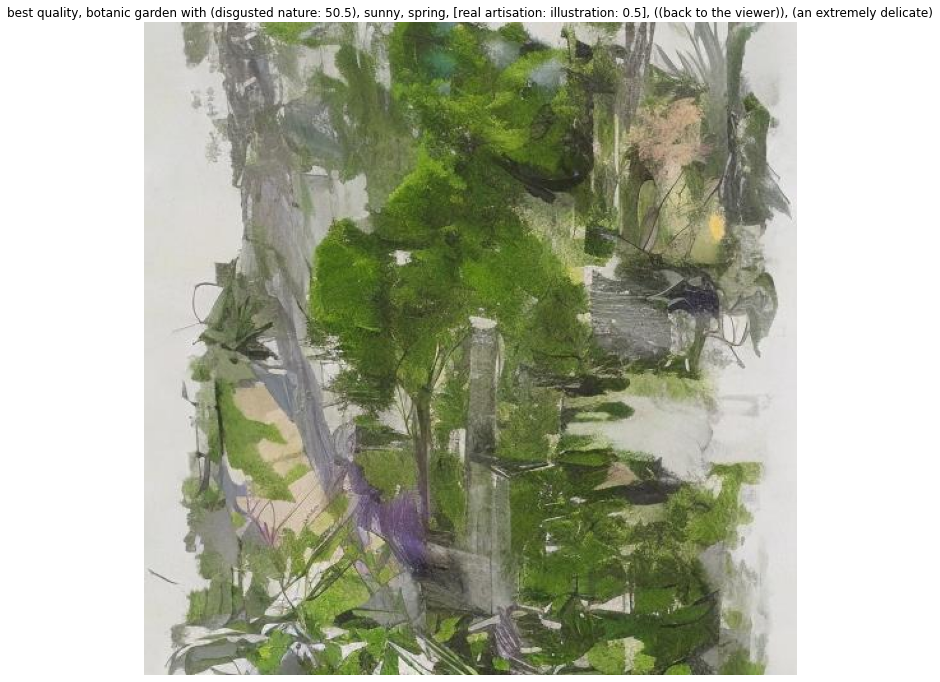

In [373]:
from PIL import Image
from io import BytesIO
import base64
import json

query_response = query_endpoint_with_json_payload(
    finetuned_predictor, payload, "application/json", "application/json;jpeg"
)

generated_images, prompt = parse_response_multiple_images(query_response)

# generated_images are a list of jpeg images as bytes with b64 encoding.


def display_encoded_images(generated_images, prompt):
    # we decode the images and convert to RGB format before displaying
    for generated_image in generated_images:
        generated_image_decoded = BytesIO(base64.b64decode(generated_image.encode()))
        generated_image_rgb = Image.open(generated_image_decoded).convert("RGB")
        display_img_and_prompt(generated_image_rgb, prompt)


display_encoded_images(generated_images, prompt)

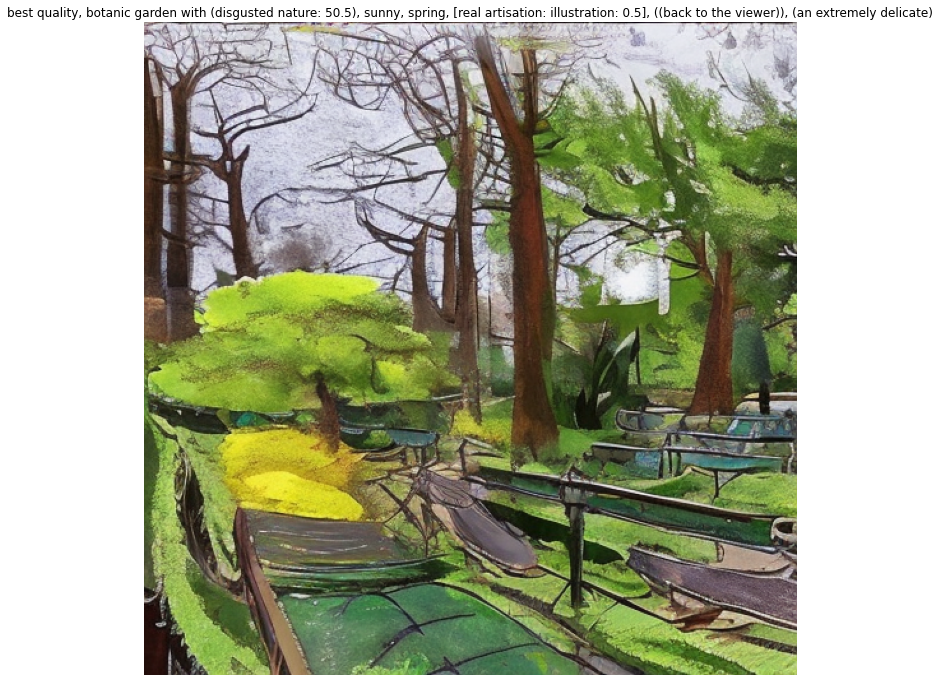

In [370]:
text = "best quality, botanic garden with (disgusted nature: 50.5), sunny, spring, [real artisation: illustration: 0.5], ((back to the viewer)), (an extremely delicate)"
query_response = query(finetuned_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

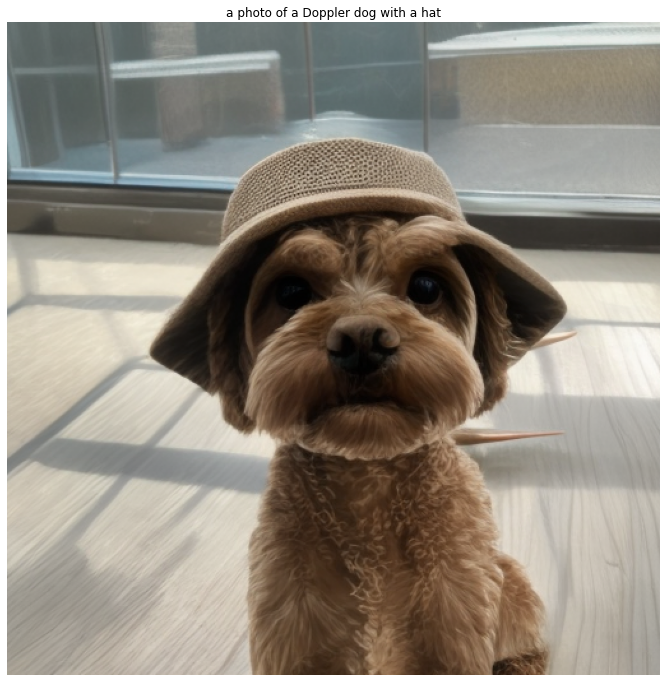

In [21]:
text = "a photo of a Doppler dog with a hat"
query_response = query(finetuned_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

All the parameters mentioned in [2.4. Supported Inference parameters](#2.4.-Supported-Inference-parameters) are supported with finetuned model as well. You may also receive compressed image output as in [2.5. Compressed Image Output](#2.5.-Compressed-Image-Output) by changing `accept`.

---
Next, we delete the endpoint corresponding to the finetuned model.

---

In [ ]:
# Delete the SageMaker endpoint
finetuned_predictor.delete_model()
finetuned_predictor.delete_endpoint()

## 3. Conclusion
---

Although creating impressive images can find use in industries ranging from art to NFTs and beyond, today we also expect AI to be personalizable. JumpStart provides fine-tuning capability to the pre-trained models so that you can adapt the model to your own use case with as little as five training images. This can be useful when creating art, logos, custom designs, NFTs, and so on, or fun stuff such as generating custom AI images of your pets or avatars of yourself. In this lab, we learned how to fine-tune a stable diffusion text to image generation model. To learn more about Stable Diffusion fine-tuning, please check out the blog [Fine-tune text-to-image Stable Diffusion models with Amazon SageMaker JumpStart](https://aws.amazon.com/blogs/machine-learning/fine-tune-text-to-image-stable-diffusion-models-with-amazon-sagemaker-jumpstart/).